<a href="https://colab.research.google.com/github/gawronn91/Airbnb/blob/main/Geneva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, explained_variance_score, max_error, mean_absolute_percentage_error, r2_score, mean_poisson_deviance
from sklearn.linear_model import lasso_path
import xgboost
!pip install shap
import shap
pd.set_option("display.max_rows", None, "display.max_columns", None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 20.6 MB/s eta 0:00:00


Getting the data

In [2]:
data = pd.read_csv('http://data.insideairbnb.com/switzerland/geneva/geneva/2022-03-28/data/listings.csv.gz')

In [3]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2365 non-null   int64  
 1   listing_url                                   2365 non-null   object 
 2   scrape_id                                     2365 non-null   int64  
 3   last_scraped                                  2365 non-null   object 
 4   name                                          2365 non-null   object 
 5   description                                   2264 non-null   object 
 6   neighborhood_overview                         1211 non-null   object 
 7   picture_url                                   2365 non-null   object 
 8   host_id                                       2365 non-null   int64  
 9   host_url                                      2365 non-null   o

Columns with missing data

In [5]:
listings_na = data.isna().sum()
listings_na[listings_na.values > 0].sort_values(ascending=False)

calendar_updated                2365
neighbourhood_group_cleansed    2365
bathrooms                       2365
license                         2356
host_neighbourhood              2342
host_about                      1155
neighborhood_overview           1154
neighbourhood                   1153
review_scores_value              517
review_scores_accuracy           517
review_scores_checkin            516
review_scores_cleanliness        516
review_scores_location           516
review_scores_communication      516
review_scores_rating             498
reviews_per_month                498
last_review                      498
first_review                     498
host_response_rate               410
host_response_time               410
bedrooms                         311
host_acceptance_rate             302
description                      101
beds                              59
host_location                      8
bathrooms_text                     4
maximum_nights_avg_ntm             1
m

Price column

In [6]:
data.describe(include="all")["price"]

count        2365
unique        308
top       $100.00
freq           91
mean          NaN
std           NaN
min           NaN
25%           NaN
50%           NaN
75%           NaN
max           NaN
Name: price, dtype: object

Converting price values from object to float

In [7]:
data["price"] = data["price"].apply(lambda x: x.replace("$", "")) # Remove dollar sign
data["price"] = data["price"].apply(lambda x: x.replace(",", "")) # Remove thousand seperator
data["price"] = data["price"].astype("float") # Cast the column into type float
data.describe(include="all")["price"]

count     2365.000000
unique            NaN
top               NaN
freq              NaN
mean       134.265116
std        146.600642
min          0.000000
25%         72.000000
50%        100.000000
75%        141.000000
max       3000.000000
Name: price, dtype: float64

In [8]:
print("99% properties have a price lower than {0: .2f}".format(np.percentile(data.price, 99)))
# Since 99% entries have a price that is lower than 761 , we choose to remove the rest as outliers.
# We would like to create a new column "price_range" for visualisations later on. The choice of cutoff points (e.g. 20, 40, 60, etc) is inspired by the quartiles of column "price".

99% properties have a price lower than  761.00


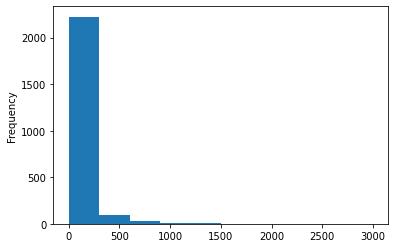

In [9]:
data.price.plot.hist()
#This data needs to be trimmed due to outliers

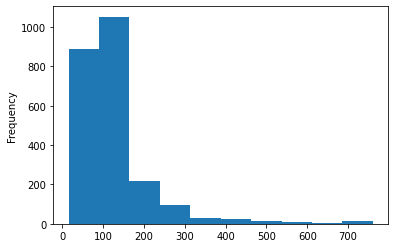

In [10]:
data = data[(data.price <= np.percentile(data["price"], 99)) & (data.price > 0)] # Exclude outliers
data.price.plot.hist()

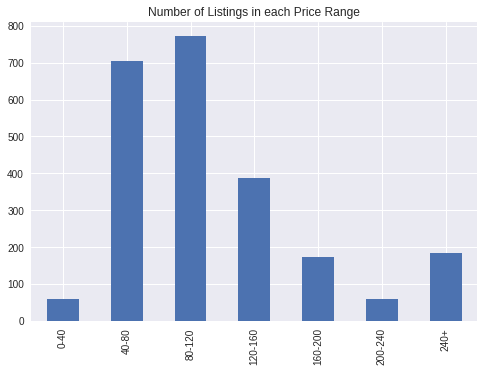

In [11]:
plt.style.use("seaborn")
price_range = pd.cut(data["price"], 
                     bins=[0, 40, 80, 120, 160, 200, 240, data["price"].max()], 
                     labels=["0-40", "40-80", "80-120", "120-160", "160-200", "200-240", "240+"])
data["price_range"] = price_range 
data["price_range"].value_counts().sort_index().plot(kind="bar")
plt.title("Number of Listings in each Price Range")
plt.show()

In [12]:
selected = []
host = ['host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_identity_verified']
location = ['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']
geo = ["latitude", "longitude"]
condition = ['property_type', 'room_type', 'bed_type', 'amenities', 'cleaning_fee', 'minimum_nights']
review = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
size = ['space', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet']
others = ['instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

#Plots about hosts

In [13]:
data.describe(include="all")[host]

,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified
count,2345,22,2345.000000,2345.000000,2345,2345
unique,2,19,NaN,NaN,159,2
top,f,La Corniche,NaN,NaN,"['email', 'phone']",t
freq,1907,3,NaN,NaN,284,2125
mean,NaN,NaN,17.912580,17.912580,NaN,NaN
std,NaN,NaN,58.693959,58.693959,NaN,NaN
min,NaN,NaN,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,1.000000,1.000000,NaN,NaN
50%,NaN,NaN,1.000000,1.000000,NaN,NaN
75%,NaN,NaN,4.000000,4.000000,NaN,NaN


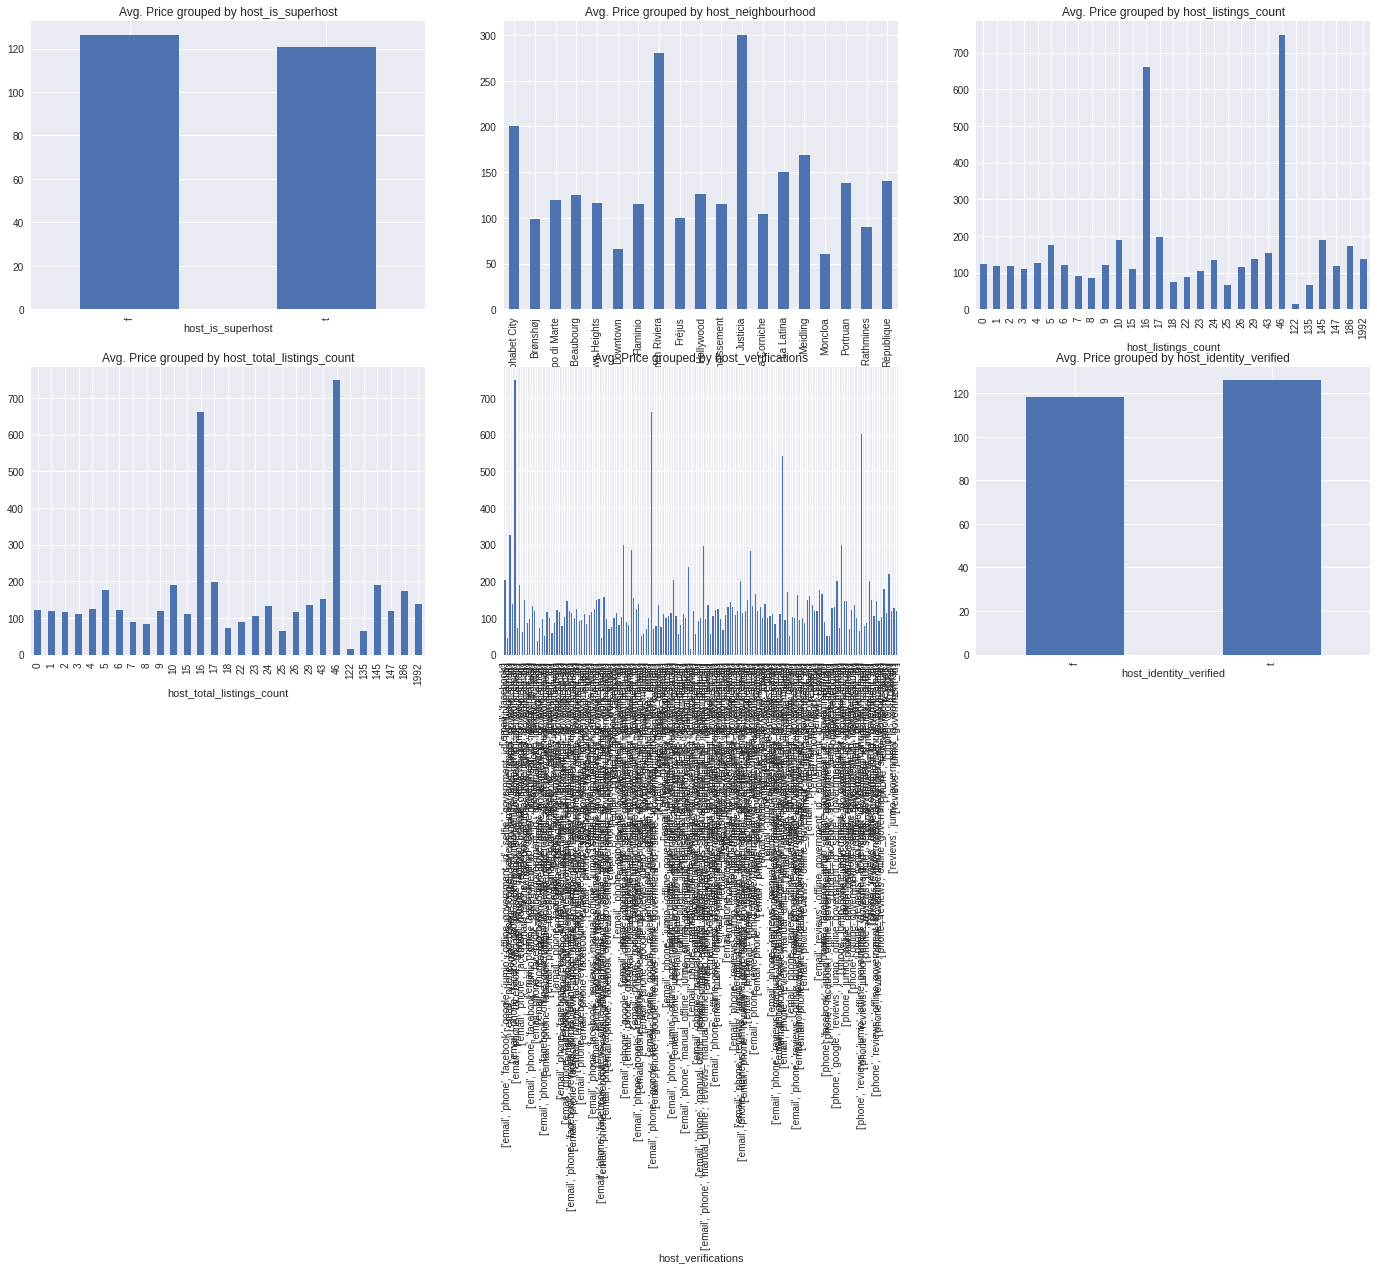

In [14]:
n_cols = 3
n_rows = np.ceil((len(host)+1)/n_cols)
i = 1
for col in host:
  plt.subplot(n_rows, n_cols, i)
  avg_price_host = data.groupby(col).mean()["price"]
  avg_price_host.plot(kind="bar", figsize=(8*n_cols, 6*n_rows))
  plt.title("Avg. Price grouped by "+col)
  i=i+1

plt.show()

In [15]:
index = []
i=0
for col in host:
  if data[col].nunique() >= 10:
    index.append(i)
    i=i+1
  else:
    i=i+1
    continue
host = np.delete(host, index)

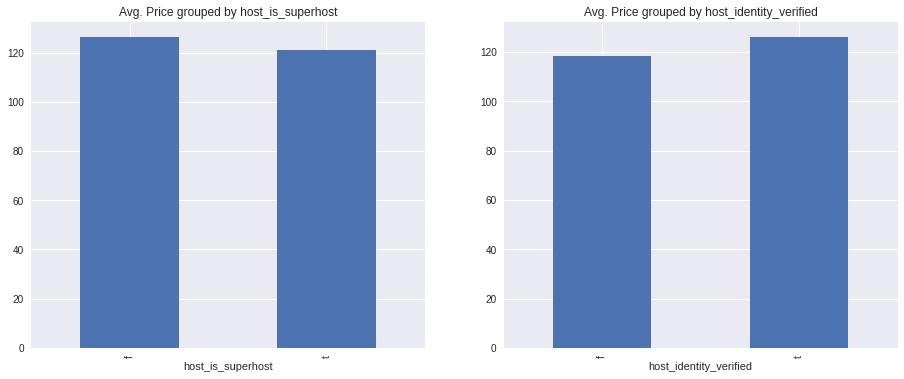

In [16]:
n_cols = 3
n_rows = np.ceil((len(host)+1)/n_cols)
i = 1
for col in host:
  plt.subplot(n_rows, n_cols, i)
  avg_price_host = data.groupby(col).mean()["price"]
  avg_price_host.plot(kind="bar", figsize=(8*n_cols, 6*n_rows))
  plt.title("Avg. Price grouped by "+col)
  i=i+1

plt.show()

#Adjusting host data

In [17]:
data["host_is_superhost"] = data["host_is_superhost"].replace(np.NAN, "f")
data["host_identity_verified"] =data["host_identity_verified"].replace(np.NAN, "f")

Now we can perform a statistical test: t-test

In [18]:
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
# Define multicomp function
def multicomp(target_name, group_name, data):
    if (np.nan in data[target_name]) | (np.nan in data[group_name]):
        print("Please remove NaN in target variable or group variable!")
    elif (data[target_name].nunique() == 1) | (data[group_name].nunique() == 1):
        print("There is only one unique value in target variable or group variable.")
    elif data[group_name].nunique() == 2:
        mod = MultiComparison(data[target_name], data[group_name])
        comp = mod.allpairtest(stats.ttest_ind)
        print(comp[0])
    else:
        mod = MultiComparison(data[target_name], data[group_name])
        print(mod.tukeyhsd().summary())
multicomp("price", "host_is_superhost", data)
multicomp("price", "host_identity_verified", data)

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval pval_corr reject
-------------------------------------------
     f      t 1.0672 0.286     0.286  False
-------------------------------------------
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
     f      t -1.1005 0.2712    0.2712  False
---------------------------------------------


Both null hypotesis were not rejected, so no value of those above shall be used

Let's handle host verifications

In [19]:
# Changing ['email', 'phone', 'reviews'] to [email, phone, reviews]
data["host_ver_types"] = data["host_verifications"].apply(lambda x: x[1:-1].replace("\'", "").split(", "))
# data["host_ver_types"]

In [20]:
# Counting number of verification types in the apartment
data["host_ver_type_counts"] = data["host_ver_types"].apply(lambda x: len(x))
#data["host_ver_type_counts"] 

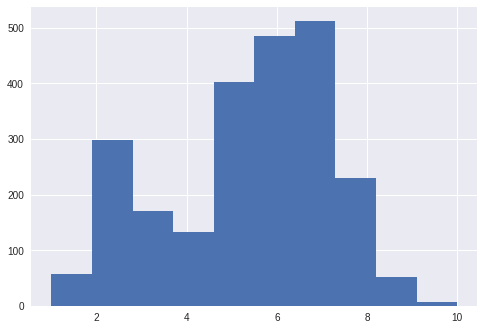

In [21]:
data["host_ver_type_counts"].hist()

In [22]:
# Here we iterate per all verification types and add to new list (with duplicates)
host_ver_types = []
for i in data["host_ver_types"]:
    host_ver_types += i

#host_ver_types

In [23]:
# Here we check count of verifications without replacement and put it in a dictionary
host_ver_types_freq = dict((x, host_ver_types.count(x)) for x in set(host_ver_types))
host_ver_types_freq

{'google': 161,
 'government_id': 1662,
 'offline_government_id': 1287,
 'facebook': 348,
 'manual_offline': 35,
 'work_email': 419,
 'phone': 2340,
 'identity_manual': 850,
 'jumio': 1107,
 'kba': 10,
 'manual_online': 10,
 'reviews': 1307,
 'selfie': 868,
 'sent_id': 1,
 'email': 2158}

In [24]:
# Creating a DataFreame from dictionary created above
host_ver_types_freq = pd.DataFrame.from_dict(host_ver_types_freq, orient="index")
# Reseting an index and changing column names
host_ver_types_freq.reset_index(inplace=True)
host_ver_types_freq.columns = ["Verification", "Frequency"]
# Picking most frequent verification types in selected order
host_ver_types_freq = host_ver_types_freq.sort_values(by="Frequency", ascending=True)
host_ver_types_freq = host_ver_types_freq[host_ver_types_freq.Frequency >25]
host_ver_types_freq

,Verification,Frequency
4,manual_offline,35
0,google,161
3,facebook,348
5,work_email,419
7,identity_manual,850
12,selfie,868
8,jumio,1107
2,offline_government_id,1287
11,reviews,1307
1,government_id,1662


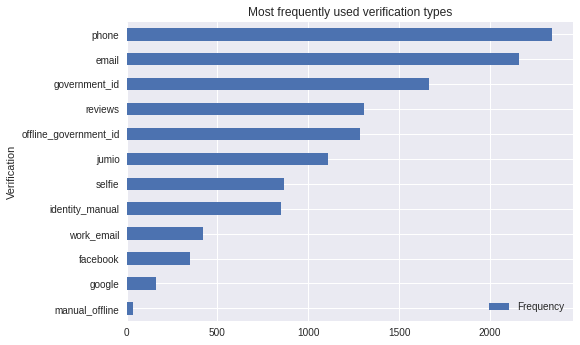

In [25]:
host_ver_types_freq.plot.barh(x="Verification", y="Frequency")
plt.title("Most frequently used verification types")
plt.show()

#Geoplot

In [26]:
import plotly.graph_objects as go
import plotly.express as px
from plotly import tools
from plotly.offline import plot as plotoffline
import seaborn as sns

Creating a dataset

In [27]:
geo = data[['latitude', 'longitude', 'price', 'price_range']]
geo = geo.sort_values("price", ascending=True) # This sorting is necessary for the color scale to work properly. 
geo.describe()

,latitude,longitude,price
count,2345.000000,2345.000000,2345.000000
mean,46.205731,6.145499,125.205117
std,0.024348,0.032681,94.677872
min,46.137480,5.962300,15.000000
25%,46.194000,6.131140,72.000000
50%,46.204070,6.144380,100.000000
75%,46.212510,6.157090,140.000000
max,46.352330,6.298880,761.000000


Simple scatter plot

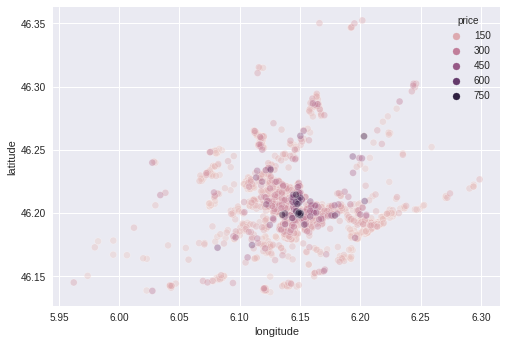

In [28]:
sns.scatterplot(x="longitude", 
                y="latitude", 
                hue="price", 
                data=geo, 
                alpha=0.4)

Below we have created map with marked prices from several ranges

In [29]:
# Map plot
from textwrap import wrap

px.set_mapbox_access_token("pk.eyJ1IjoiZ2F3cm9ubiIsImEiOiJjbDNzeXllNWkxMnl4M2psdHRtZGZkODh0In0.hSntC8Rp50ICzYyvo606nA") # Replace XXX with your Mapbox Token

#Token created here: https://account.mapbox.com/access-tokens 
#I think, that simmilar map could be generated via one of books from python - ćwiczenia
fig = px.scatter_mapbox(geo, 
                        lat="latitude", 
                        lon="longitude", 
                        color="price_range",
                        color_continuous_scale=px.colors.sequential.Aggrnyl,# Na tej stronie można sobie wybierać różne skale kolorów https://plotly.com/python/builtin-colorscales/
                        opacity=0.9, 
                        zoom=10)
fig.show()

In [30]:
data.neighbourhood_cleansed.unique()

array(['Commune de Genève', 'Versoix', 'Lancy', 'Genthod',
       'Grand-Saconnex', 'Carouge', 'Vernier', 'Thônex', 'Presinge',
       'Chêne-Bourg', 'Bellevue', 'Veyrier', 'Soral', 'Chêne-Bougeries',
       'Troinex', 'Cologny', 'Plan-les-Ouates', 'Avully', 'Collex-Bossy',
       'Vandoeuvres', 'Cartigny', 'Onex', 'Satigny', 'Meyrin',
       'Pregny-Chambésy', 'Confignon', 'Collonge-Bellerive', 'Bardonnex',
       'Perly-Certoux', 'Céligny', 'Bernex', 'Laconnex', 'Hermance',
       'Meinier', 'Puplinge', 'Corsier', 'Anières', 'Jussy', 'Gy',
       'Russin', 'Chancy', 'Dardagny', 'Choulex'], dtype=object)

Top 5 places in Geneva are:

Jet d’Eau: 46.20781920740878, 6.1559458078945575

UN: 46.22722304906608, 6.14029219999106

Geneva flower clock & Jardin Anglais: 46.20651003559838, 6.151676906400394

Parc Des Eaux Vives: 46.210636056069006, 6.167380187678211

St Pierre Cathedral: 46.20170590767383, 6.148515900004998

Calcuate the distance bwteen the listing and mianat tractions in Geneva

In [31]:
# Formula to calculate distances
from math import sin, cos, sqrt, atan2, radians
def distance(lat1, lat2, lon1, lon2):
    R = 6373.0
    rlat1 = radians(lat1)
    rlat2 = radians(lat2)
    rlon1 = radians(lon1)
    rlon2 = radians(lon2)
    rdlon = rlon2 - rlon1
    rdlat = rlat2 - rlat1
    a = sin(rdlat / 2)**2 + cos(rlat1) * cos(rlat2) * sin(rdlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [32]:
# Top locations in Riga
toploc = {"Jet": [46.20781920740878, 6.1559458078945575], 
          "UN": [46.22722304906608, 6.14029219999106], 
          "Jardin": [46.20651003559838, 6.151676906400394], 
          "Parc": [46.210636056069006, 6.167380187678211], 
          "Cathedral": [46.20170590767383, 6.148515900004998]}

In [33]:
toploc = pd.DataFrame.from_dict(toploc)
toploc_trans = toploc.transpose()
toploc_trans.columns = ["latitude", "longitude"]

In [34]:
# Draw a plot with top locations

fig = px.scatter_mapbox(toploc_trans, 
                        lat="latitude", 
                        lon="longitude", 
                        zoom=10)
fig.show()

In [35]:
# Construct distance columns
dist = []
for col in toploc.columns:
    data["dist_"+col] = data.apply(lambda x: distance(x.latitude, toploc[col][0], x.longitude, toploc[col][1]), axis=1)
    dist.append("dist_"+col)

# In "dist" list there are names of all hot locations
# Here we are counting the distance between an apartment nand selected hot location. So we have 5 new numerical columns.

Below 5 last columns

In [36]:
data.iloc[:5, -5:]

,dist_Jet,dist_UN,dist_Jardin,dist_Parc,dist_Cathedral
0,0.717183,3.089296,0.625535,1.397634,0.505712
1,1.254943,3.708513,1.264321,1.595850,1.076072
2,8.013605,6.166811,8.199858,7.653059,8.765515
3,1.044397,1.507439,0.964988,1.687330,1.410923
4,0.123042,2.545061,0.277965,1.024967,0.770139


The correlation between price and dist_Jet is -0.1330 with a p-value of  0.0000.
The correlation between price and dist_UN is -0.1102 with a p-value of  0.0000.
The correlation between price and dist_Jardin is -0.1316 with a p-value of  0.0000.
The correlation between price and dist_Parc is -0.1280 with a p-value of  0.0000.
The correlation between price and dist_Cathedral is -0.1254 with a p-value of  0.0000.


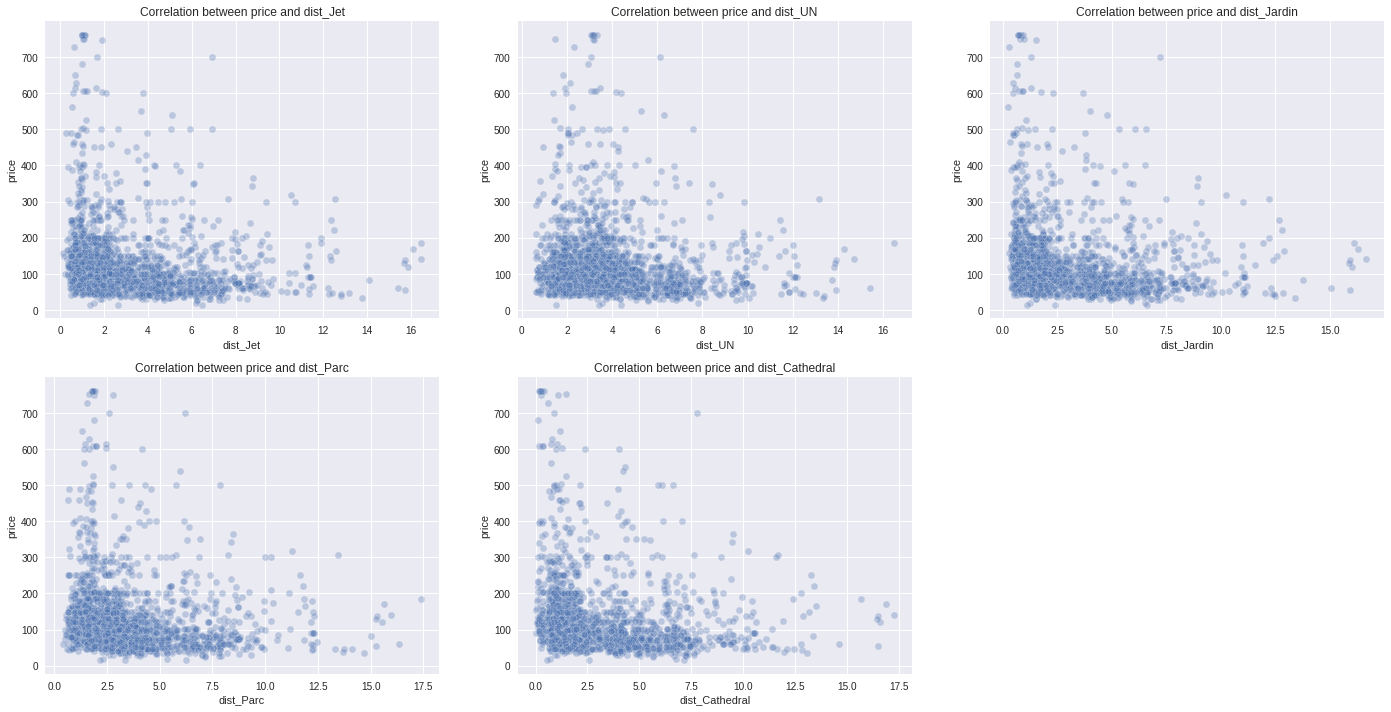

In [37]:
# Here we count and plot Pearson correlation between distance to selected top location and a price
n_cols = 3
n_rows = np.ceil((len(dist)+1)/n_cols)
i = 1
plt.figure(figsize=(8*n_cols, 6*n_rows))
for distance in dist:
  plt.subplot(n_rows, n_cols, i)
  sns.scatterplot(x=distance, y="price", data=data, alpha=0.3)
  plt.title("Correlation between price and "+distance)
  i=i+1
  print("The correlation between price and "+distance+ " is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(data[-data[distance].isna()][distance], data[-data[distance].isna()]["price"])))

plt.show()

Corellation is high everywhere and p value is always 0

In [38]:
# Next step is to categorize distance columns to True, False (Close, Not close)
for distance in dist:
   data[distance+"_close"] = (data[distance] < 0.8 * (data[distance].median()))
   print(data.groupby(distance+"_close").mean()["price"])

# Finaly we can add one last column with the verdict - can we mark an appartment as well located
toploc_column_names = ['dist_{0}_close'.format(i) for i in toploc.columns]
data["good_distance"] = data.apply(lambda x: any(x[col] for col in toploc_column_names), axis=1)

dist_Jet_close
False    113.156716
True     145.594719
Name: price, dtype: float64
dist_UN_close
False    123.305951
True     128.879850
Name: price, dtype: float64
dist_Jardin_close
False    112.800139
True     144.801980
Name: price, dtype: float64
dist_Parc_close
False    111.175658
True     151.053333
Name: price, dtype: float64
dist_Cathedral_close
False    113.437151
True     143.662651
Name: price, dtype: float64


We can see histogram below, which informs us, that mean price of locations with small distance to top 5 attractions in the city is higher.

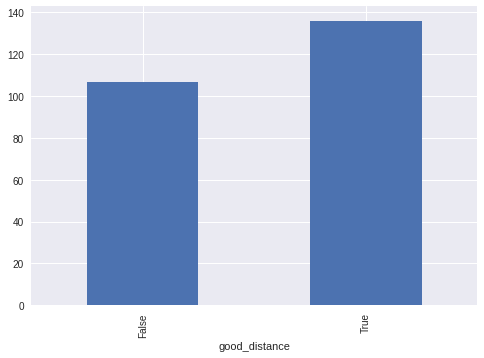

In [39]:
data.groupby("good_distance").mean()["price"].plot(kind="bar")
plt.show()

In [40]:
data.iloc[:5, -6:]

,dist_Jet_close,dist_UN_close,dist_Jardin_close,dist_Parc_close,dist_Cathedral_close,good_distance
0,True,False,True,True,True,True
1,True,False,True,True,True,True
2,False,False,False,False,False,False
3,True,True,True,True,False,True
4,True,True,True,True,True,True


We can append then this criterion to our selected table:

In [41]:
selected.append("good_distance")
selected

['good_distance']

#Neighbourhood statistics

We would also like to check the popularity and price level at each neighbourhood of Geneva.

In [42]:
# Top popular nerghbourhoods
neighbourhood_group_pop = pd.DataFrame(data["neighbourhood_cleansed"].value_counts())
neighbourhood_group_pop.head(5)

,neighbourhood_cleansed
Commune de Genève,1477
Thônex,139
Carouge,89
Grand-Saconnex,56
Vernier,54


In [43]:
# Average price of each neighbourhood
neighbourhood_group_price = data.groupby("neighbourhood_cleansed").mean()["price"]
neighbourhood_group_price = pd.DataFrame(neighbourhood_group_price)
neighbourhood_group_price.sort_values("price", ascending=False).head(5)

,price
neighbourhood_cleansed,
Collonge-Bellerive,229.636364
Vandoeuvres,214.000000
Hermance,196.800000
Confignon,194.000000
Genthod,191.500000


In [44]:
# Create neighbourhood stats
neighbourhood_stat = pd.merge(neighbourhood_group_pop, 
                              neighbourhood_group_price, 
                              how="inner", left_index=True, right_index=True)
neighbourhood_stat.reset_index(inplace=True)
neighbourhood_stat.columns = ["neighbourhood_cleansed", "count_properties", "avg_price"]
neighbourhood_stat = neighbourhood_stat.sort_values(by="count_properties", ascending=False)
neighbourhood_stat.head(10)

,neighbourhood_cleansed,count_properties,avg_price
0,Commune de Genève,1477,134.165200
1,Thônex,139,75.510791
2,Carouge,89,105.460674
3,Grand-Saconnex,56,146.375000
4,Vernier,54,90.907407
5,Meyrin,52,87.326923
6,Bellevue,52,108.000000
7,Lancy,43,112.697674
8,Versoix,37,115.270270
9,Chêne-Bougeries,36,140.194444


In [45]:
#Addition of filter, which consists of neighbourhoods with at least XXXX properties
neighbourhood_stat_limited = neighbourhood_stat[neighbourhood_stat['count_properties']>40]

<Figure size 576x396 with 0 Axes>

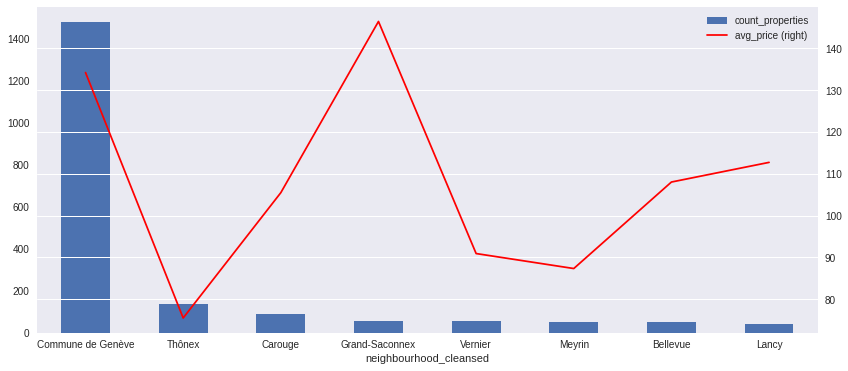

In [46]:
#Drawing a plot with relation - No. of properties vs avg price in selected neighbourhood
fig = plt.figure()
ax = neighbourhood_stat_limited.plot(x="neighbourhood_cleansed", y="count_properties", kind="bar", figsize=(14, 6))
neighbourhood_stat_limited.plot(x="neighbourhood_cleansed", y="avg_price", secondary_y=True, color="red", ax=ax)
plt.show()

#Condition statistics

We would also like to check the impact of conditions.

In [47]:
condition = ['property_type', 'room_type', 'amenities', 'minimum_nights', 'maximum_nights']

In [48]:
data[condition].head()

,property_type,room_type,amenities,minimum_nights,maximum_nights
0,Private room in rental unit,Private room,"[""Refrigerator"", ""Oven"", ""Kitchen"", ""TV with s...",3,1125
1,Private room in rental unit,Private room,"[""Safe"", ""Free dryer \u2013 In unit"", ""Refrige...",1,90
2,Entire rental unit,Entire home/apt,"[""Fire pit"", ""Baby bath"", ""Refrigerator"", ""Out...",7,360
3,Entire rental unit,Entire home/apt,"[""Paid parking garage off premises"", ""Refriger...",7,1125
4,Entire rental unit,Entire home/apt,"[""Free dryer \u2013 In unit"", ""Refrigerator"", ...",4,365


property type

In [49]:
# Table with selected property type and average price per property type
prop_type_avg_price = data.groupby("property_type").mean()["price"]
prop_type_count_listings = data["property_type"].value_counts()
prop_type_stat = pd.merge(prop_type_count_listings, prop_type_avg_price, how="inner", left_index=True, right_index=True)
prop_type_stat.columns = ["count_prop", "avg_price"]
prop_type_stat.sort_values(by="count_prop", ascending=False).head(10)

,count_prop,avg_price
Entire rental unit,1218,135.240558
Private room in rental unit,411,71.622871
Entire condominium (condo),174,141.465517
Entire serviced apartment,113,141.141593
Private room in residential home,68,83.529412
Private room in condominium (condo),61,66.049180
Entire residential home,46,246.695652
Private room in bed and breakfast,37,72.216216
Entire loft,29,181.586207
Room in hotel,29,247.413793


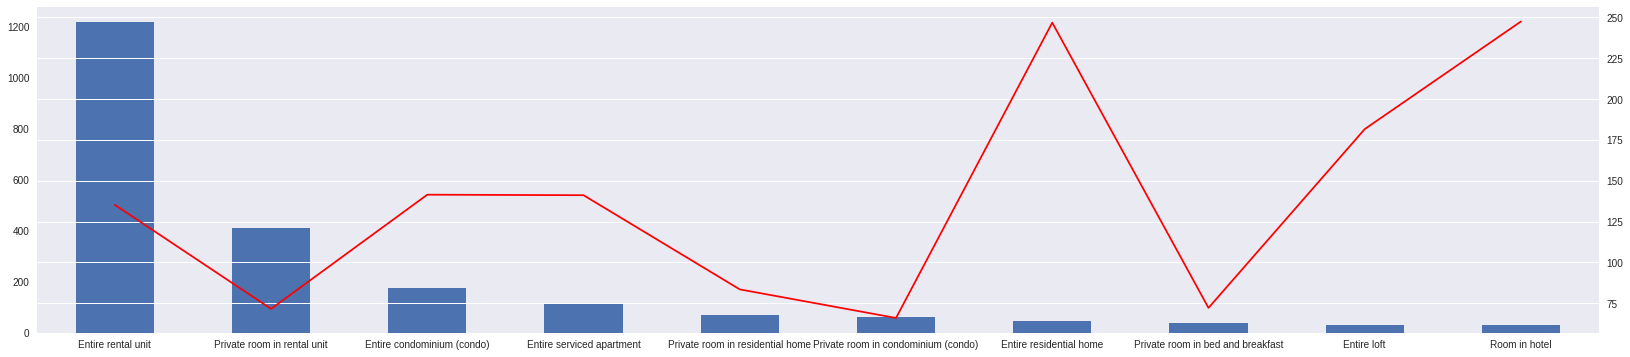

In [50]:
# Drawing a plot with relation - No. of properties vs avg price in selected property type
prop_type_stat_limited = prop_type_stat[prop_type_stat['count_prop']>20] #Trzeba było ograniczyć liczbe rodzajów lokli
fig = plt.figure()
ax = prop_type_stat_limited['count_prop'].plot(x="neighbourhood_cleansed", y="count_properties", kind="bar", figsize=(28, 6))
prop_type_stat_limited['avg_price'].plot(x="neighbourhood_cleansed", y="avg_price", secondary_y=True, color="red", ax=ax)
plt.show()

Room type

In [51]:
# Table with selected room type and average price per room type
room_type_avg_price = data.groupby("room_type").mean()["price"]
room_type_count_listings = data["room_type"].value_counts()
room_type_stat = pd.merge(room_type_count_listings, room_type_avg_price, how="inner", left_index=True, right_index=True)
room_type_stat.columns = ["count_prop", "avg_price"]
room_type_stat.sort_values(by="count_prop", ascending=False).head(10)

,count_prop,avg_price
Entire home/apt,1651,141.997577
Private room,673,82.451709
Shared room,14,161.428571
Hotel room,7,202.571429


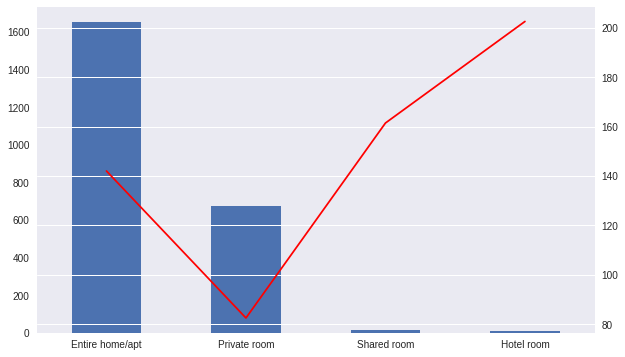

In [52]:
#Drawing a plot with relation - No. of properties vs avg price in selected room type
fig = plt.figure()
ax = room_type_stat['count_prop'].plot(x="neighbourhood_cleansed", y="count_properties", kind="bar", figsize=(10, 6))
room_type_stat['avg_price'].plot(x="neighbourhood_cleansed", y="avg_price", secondary_y=True, color="red", ax=ax)
plt.show()

Entire apartment has a significant higher price than a private room. Therefore we take it into our model.

In [53]:
data["is_entire_apt"] = data["room_type"]=="Entire home/apt"
selected.append("is_entire_apt")

Amendities

In [54]:
data["amenities"].head()

0    ["Refrigerator", "Oven", "Kitchen", "TV with s...
1    ["Safe", "Free dryer \u2013 In unit", "Refrige...
2    ["Fire pit", "Baby bath", "Refrigerator", "Out...
3    ["Paid parking garage off premises", "Refriger...
4    ["Free dryer \u2013 In unit", "Refrigerator", ...
Name: amenities, dtype: object

In [55]:
data["amenities"] =data["amenities"].apply(lambda x: x[1:-1].replace("\'", "").replace(' "', '').replace('"', '').split(","))
data["amenities"].head()

0    [Refrigerator, Oven, Kitchen, TV with standard...
1    [Safe, Free dryer \u2013 In unit, Refrigerator...
2    [Fire pit, Baby bath, Refrigerator, Outdoor fu...
3    [Paid parking garage off premises, Refrigerato...
4    [Free dryer \u2013 In unit, Refrigerator, Oven...
Name: amenities, dtype: object

In [56]:
# Listing all amenities
amenity_types = []
for i in data["amenities"]:
    amenity_types += i
#amenity_types

In [57]:
# Table with amenities and their frequency
amenity_types_freq = dict((x, amenity_types.count(x)) for x in set(amenity_types))
amenity_types_freq = pd.DataFrame.from_dict(amenity_types_freq, orient="index")
amenity_types_freq.reset_index(inplace=True)
amenity_types_freq.columns = ["Amenity", "Frequency"]
amenity_types_freq = amenity_types_freq.sort_values(by="Frequency", ascending=False)
amenity_types_freq.head(25)

,Amenity,Frequency
349,Wifi,2185
44,Kitchen,2167
247,Essentials,2110
220,Long term stays allowed,2024
514,Heating,1883
293,Hangers,1868
126,Iron,1855
286,Hot water,1744
209,Hair dryer,1677
288,Dedicated workspace,1575


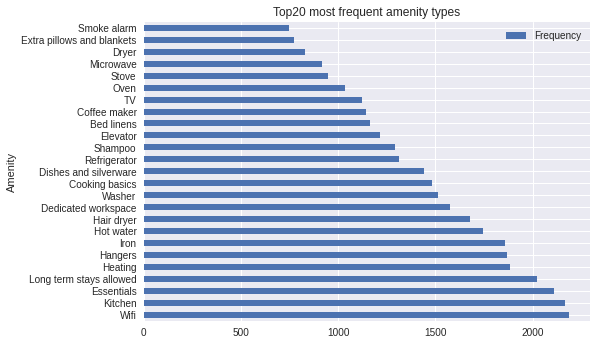

In [58]:
# Plot with top amenities
amenity_types_freq.head(25).plot.barh(x="Amenity", y="Frequency")
plt.title("Top20 most frequent amenity types")
plt.show()

90%+ listings have the Top3 features: kitchen, Essentials and heatLong term stays allowed. Therefore they won't have a huge impact on price. We choose to focuse on features that ~50% listings have. They are:

Hot Water

Hair dryer

Dedicated workspace

Washer

Cooking basics

Dishes and silverware

Refrigerator

Shampoo

Elevator

Bed linens

Cofee maker

TV

Oven

Stove

Microwave

In [59]:
# Creating new dummy columns for selected amenities
data["with_Hot_Water"] = data["amenities"].apply(lambda x: 'Hot Water' in x)
data["with_Hair_dryer"] =data["amenities"].apply(lambda x: 'Hair dryer' in x)
data["with_Dedicated_workspace"] = data["amenities"].apply(lambda x: 'Dedicated workspace' in x)
data["with_Washer"] = data["amenities"].apply(lambda x: 'Washer' in x)
data["with_Cooking_basics"] = data["amenities"].apply(lambda x: 'Cooking basics' in x)
data["with_Dishes_and_silverware"] =data["amenities"].apply(lambda x: 'Dishes and silverware' in x)
data["with_Refrigerator"] = data["amenities"].apply(lambda x: 'Refrigerator' in x)
data["with_Shampoo"] = data["amenities"].apply(lambda x: 'Shampoo' in x)
data["with_Elevator"] = data["amenities"].apply(lambda x: 'Elevator' in x)
data["with_Bed_linens"] =data["amenities"].apply(lambda x: 'Bed linens' in x)
data["with_Coffee_maker"] = data["amenities"].apply(lambda x: 'Coffee maker' in x)
data["with_TV"] = data["amenities"].apply(lambda x: 'TV' in x)
data["with_Oven"] =data["amenities"].apply(lambda x: 'Oven' in x)
data["with_Stove"] = data["amenities"].apply(lambda x: 'Stove' in x)
data["with_Microwave"] = data["amenities"].apply(lambda x: 'Microwave' in x)

In [60]:
data.iloc[:10, -15:]

,with_Hot_Water,with_Hair_dryer,with_Dedicated_workspace,with_Washer,with_Cooking_basics,with_Dishes_and_silverware,with_Refrigerator,with_Shampoo,with_Elevator,with_Bed_linens,with_Coffee_maker,with_TV,with_Oven,with_Stove,with_Microwave
0,False,True,True,True,True,True,True,False,True,False,False,False,True,True,False
1,False,True,True,False,True,True,True,True,True,True,True,False,True,True,True
2,False,True,True,False,True,True,True,False,False,True,True,True,True,True,True
3,False,True,False,True,True,True,True,False,True,True,True,True,True,False,False
4,False,True,True,False,True,True,True,True,True,False,True,False,True,True,True
5,False,True,False,True,True,True,True,False,True,False,False,False,True,True,True
6,False,True,True,True,True,True,True,True,True,True,True,False,True,True,False
7,False,True,False,False,True,True,True,True,True,True,True,False,True,True,False
8,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True
9,False,True,False,True,False,True,True,False,True,True,True,True,False,True,True


In [61]:
# Performing statistical test for selected amenities
for amenit in data.iloc[:, -15:].columns:
  print(amenit)
  print(multicomp("price", amenit, data))

with_Hot_Water
There is only one unique value in target variable or group variable.
None
with_Hair_dryer
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat  pval pval_corr reject
-------------------------------------------
 False   True -5.3262  0.0       0.0   True
-------------------------------------------
None
with_Dedicated_workspace
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
 False   True -3.7206 0.0002    0.0002   True
---------------------------------------------
None
with_Washer
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
 False   True -1.9723 0.0487    0.0487   True
---------------------------------------------
None
with_Cooking_basics


We can reject null hypotesis for:

Hair dryer

Dedicated workspace

Washer

Shampoo

Cofee maker

In [ ]:
for i in ["with_Hair_dryer", "with_Dedicated_workspace", "with_Washer", "with_Shampoo", "with_Coffee_maker"]:
    selected.append(i)

In [ ]:
selected

['good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Dedicated_workspace',
 'with_Washer',
 'with_Shampoo',
 'with_Coffee_maker']

Minimum nights

In [ ]:
data["minimum_nights"].describe()

count    2345.000000
mean        7.356930
std        29.258456
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      1100.000000
Name: minimum_nights, dtype: float64

In [ ]:
for i in range(2, 10):
  data['min_nights_greater_than_{}'.format(i)] = data["minimum_nights"] > i
  multicomp("price", 'min_nights_greater_than_{}'.format(i), data=data)
data.iloc[:10, -8:]

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
 False   True -0.7088 0.4785    0.4785  False
---------------------------------------------
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
 False   True 1.7052 0.0883    0.0883  False
--------------------------------------------
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
 False   True 0.8789 0.3795    0.3795  False
--------------------------------------------
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat  pval  pval_corr reject
----------------------------------------

,min_nights_greater_than_2,min_nights_greater_than_3,min_nights_greater_than_4,min_nights_greater_than_5,min_nights_greater_than_6,min_nights_greater_than_7,min_nights_greater_than_8,min_nights_greater_than_9
0,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,True,True,True,True,True,False,False,False
3,True,True,True,True,True,False,False,False
4,True,True,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False
7,True,False,False,False,False,False,False,False
8,True,False,False,False,False,False,False,False
9,True,True,True,True,True,False,False,False


We can saee, that p value is on proper value after min 7 nights - so it shall not be taken under consideration, due to clear negative impact after this value

Lets see about maximum nights

In [ ]:
data["maximum_nights"].describe()

count    2345.000000
mean      623.395736
std       500.254755
min         1.000000
25%        60.000000
50%       365.000000
75%      1125.000000
max      1125.000000
Name: maximum_nights, dtype: float64

It is hard to estimate something here, so lets ged rid of this max nights criterion

#Review statistics

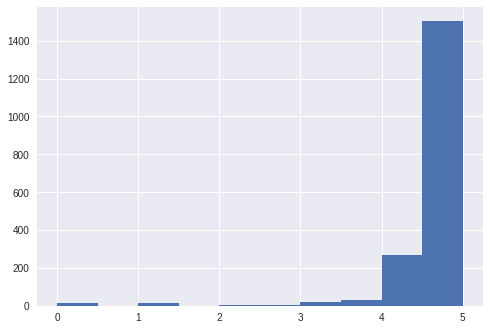

In [ ]:
data["review_scores_rating"].hist()

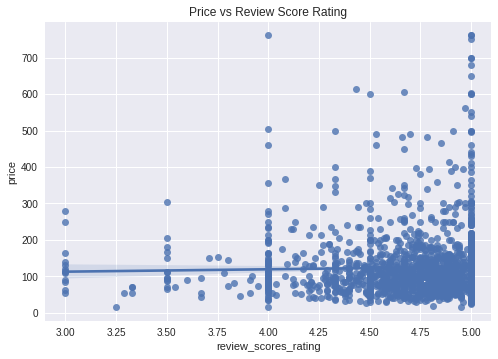

The correlation between review score and price is  0.0341 with a p-value of  0.1416.


In [ ]:
# Scatter plot between review score and price
import seaborn as sns
import scipy.stats as stats
sns.regplot(x="review_scores_rating", y="price", data=data[data["review_scores_rating"]>=3])
plt.title("Price vs Review Score Rating")
plt.show()
print("The correlation between review score and price is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(data[-data["review_scores_rating"].isna()]["review_scores_rating"], data[-data["review_scores_rating"].isna()]["price"])))

Check the correlation between price and other scores

In [ ]:
for col in review:
    print(("The pearson correlation coefficient between " + col + " and price is {0[0]: .4f} with a p-value of {0[1]: .4f}.").format(stats.pearsonr(data[-data[col].isna()][col],data[-data[col].isna()]["price"])))

The pearson correlation coefficient between review_scores_rating and price is  0.0341 with a p-value of  0.1416.
The pearson correlation coefficient between review_scores_accuracy and price is  0.0223 with a p-value of  0.3391.
The pearson correlation coefficient between review_scores_cleanliness and price is  0.0567 with a p-value of  0.0151.
The pearson correlation coefficient between review_scores_checkin and price is  0.0605 with a p-value of  0.0095.
The pearson correlation coefficient between review_scores_communication and price is  0.0295 with a p-value of  0.2063.
The pearson correlation coefficient between review_scores_location and price is  0.0571 with a p-value of  0.0143.
The pearson correlation coefficient between review_scores_value and price is  0.0017 with a p-value of  0.9436.


Here we can see, that corelation is significant for:

review_scores_cleanliness

review_scores_checkin

review_scores_location

In [ ]:
for i in ["review_scores_cleanliness", "review_scores_checkin", "review_scores_location"]:
    selected.append(i)

In [ ]:
selected

['good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Dedicated_workspace',
 'with_Washer',
 'with_Shampoo',
 'with_Coffee_maker',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_location']

#Size of apartment

Look at size-related variables

In [ ]:
#Need to adjust data to Geneva provided columns
size = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
data[size].head(10)

,accommodates,bathrooms,bedrooms,beds
0,1,NaN,1.0,1.0
1,1,NaN,1.0,1.0
2,4,NaN,1.0,3.0
3,2,NaN,1.0,1.0
4,2,NaN,1.0,1.0
5,1,NaN,1.0,1.0
6,2,NaN,1.0,1.0
7,1,NaN,1.0,1.0
8,5,NaN,3.0,4.0
9,8,NaN,4.0,4.0


In [ ]:
data['bathrooms'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bathrooms, dtype: float64

it occour, that there are no valuable info in bathrooms column

In [ ]:
data['bathrooms_text'].unique()

array(['1.5 shared baths', '1 bath', '1.5 baths', '2.5 baths',
       '1 private bath', '2 baths', '1 shared bath', nan,
       '2 shared baths', '4 baths', 'Shared half-bath',
       '2.5 shared baths', '3 baths', '3 shared baths', '6 baths',
       '3.5 baths', '0 shared baths', 'Half-bath', '4.5 baths',
       '6 shared baths'], dtype=object)

But we count find something interesting in 'bathrooms_text column'

In [ ]:
data['bathrooms'] = np.where(data['bathrooms_text'].str.contains('half',case=False, na=False), 0.5, 
                          data['bathrooms_text'].str.split().str[0]).astype(np.float64)
data[size].head(10)

,accommodates,bathrooms,bedrooms,beds
0,1,1.5,1.0,1.0
1,1,1.5,1.0,1.0
2,4,1.0,1.0,3.0
3,2,1.5,1.0,1.0
4,2,1.5,1.0,1.0
5,1,1.5,1.0,1.0
6,2,1.5,1.0,1.0
7,1,1.0,1.0,1.0
8,5,2.5,3.0,4.0
9,8,1.5,4.0,4.0


Check the correlation between number of accommodates and price

In [ ]:
data["accommodates"].describe()

count    2345.000000
mean        2.672068
std         1.479787
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        15.000000
Name: accommodates, dtype: float64

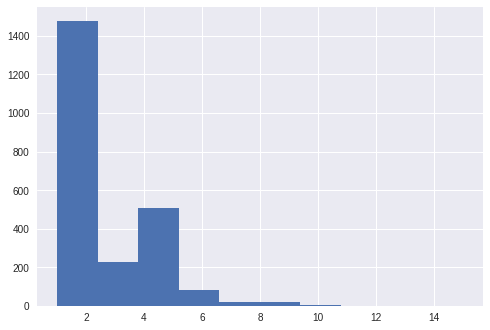

In [ ]:
data["accommodates"].hist()

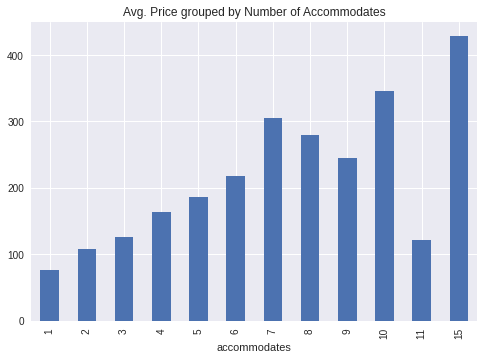

The pearson correlation coefficient between ther number of acoommodates and price is  0.4464 with a p-value of  0.0000.


In [ ]:
data.groupby("accommodates").mean()["price"].plot(kind="bar")
plt.title("Avg. Price grouped by Number of Accommodates")
plt.show()
print("The pearson correlation coefficient between ther number of acoommodates and price is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(data["accommodates"], data["price"])))

Accommodates can be used as a proxy of space and has sig. correlation with price.

In [ ]:
selected.append("accommodates")
selected

['good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Dedicated_workspace',
 'with_Washer',
 'with_Shampoo',
 'with_Coffee_maker',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_location',
 'accommodates']

Check the correlation bewteen accommodates and other size variables

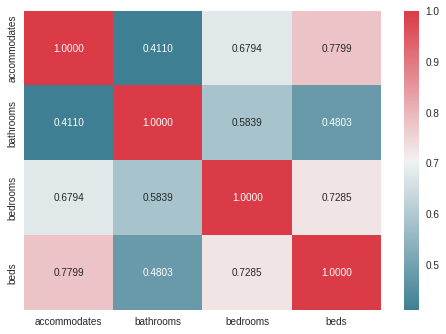

In [ ]:
size_variables = data[size]
size_corr = size_variables.corr()
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(size_corr, cmap=colormap, annot=True, fmt=".4f")

Conclusion: the variable "accommodates" is highly correlated with "beds" and "bedrooms", so it is sufficient to include only accommodates into our model.

nevertheless, due to bedrooms is more important factor, when we are concluding buying apartment - i will add this factor too.

In [ ]:
selected.append("bedrooms")
selected

['good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Dedicated_workspace',
 'with_Washer',
 'with_Shampoo',
 'with_Coffee_maker',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_location',
 'accommodates',
 'bedrooms']

#Other conditions

In [ ]:
# I had to limit it due to Geneva data
others = ['instant_bookable']
data[others].head()

,instant_bookable
0,f
1,f
2,t
3,f
4,t


Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat  pval pval_corr reject
-------------------------------------------
     f      t -4.6479  0.0       0.0   True
-------------------------------------------


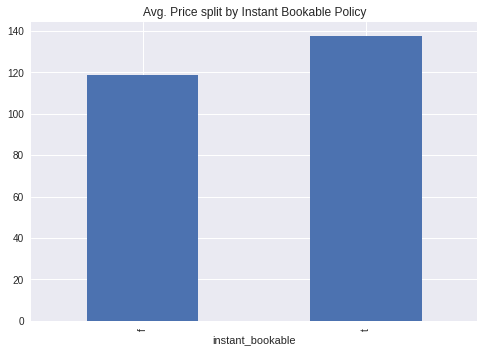

In [ ]:
data["instant_bookable"].value_counts()
multicomp("price", "instant_bookable", data)
data.groupby("instant_bookable").mean()["price"].plot(kind="bar")
plt.title("Avg. Price split by Instant Bookable Policy")
plt.show()

We can add instant bookable then

In [ ]:
selected.append("instant_bookable")
selected

['good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Dedicated_workspace',
 'with_Washer',
 'with_Shampoo',
 'with_Coffee_maker',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_location',
 'accommodates',
 'bedrooms',
 'instant_bookable']

We have all selected values!!!

#Feature engineering

In [ ]:
data[selected].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345 entries, 0 to 2364
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   good_distance              2345 non-null   bool   
 1   is_entire_apt              2345 non-null   bool   
 2   with_Hair_dryer            2345 non-null   bool   
 3   with_Dedicated_workspace   2345 non-null   bool   
 4   with_Washer                2345 non-null   bool   
 5   with_Shampoo               2345 non-null   bool   
 6   with_Coffee_maker          2345 non-null   bool   
 7   review_scores_cleanliness  1839 non-null   float64
 8   review_scores_checkin      1839 non-null   float64
 9   review_scores_location     1839 non-null   float64
 10  accommodates               2345 non-null   int64  
 11  bedrooms                   2036 non-null   float64
 12  instant_bookable           2345 non-null   object 
dtypes: bool(7), float64(4), int64(1), object(1)
memo

Convert string variables into categorical variables

In [ ]:
data["instant_bookable"] = data["instant_bookable"]=="t"

In [ ]:
for col in data[selected].select_dtypes("bool").columns:
    data[col] = data[col].astype("int")

In [ ]:
data[selected].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345 entries, 0 to 2364
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   good_distance              2345 non-null   int64  
 1   is_entire_apt              2345 non-null   int64  
 2   with_Hair_dryer            2345 non-null   int64  
 3   with_Dedicated_workspace   2345 non-null   int64  
 4   with_Washer                2345 non-null   int64  
 5   with_Shampoo               2345 non-null   int64  
 6   with_Coffee_maker          2345 non-null   int64  
 7   review_scores_cleanliness  1839 non-null   float64
 8   review_scores_checkin      1839 non-null   float64
 9   review_scores_location     1839 non-null   float64
 10  accommodates               2345 non-null   int64  
 11  bedrooms                   2036 non-null   float64
 12  instant_bookable           2345 non-null   int64  
dtypes: float64(4), int64(9)
memory usage: 256.5 KB


Standardisation

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaledFeatures = sc.fit_transform(data[selected])
scaledFeatures

array([[ 0.65099988, -1.54238858,  0.63113418, ..., -1.13017939,
        -0.44853317, -0.73810283],
       [ 0.65099988, -1.54238858,  0.63113418, ..., -1.13017939,
        -0.44853317, -0.73810283],
       [-1.53609858,  0.64834505,  0.63113418, ...,  0.89757169,
        -0.44853317,  1.35482478],
       ...,
       [ 0.65099988,  0.64834505, -1.58444913, ..., -0.45426236,
        -0.44853317,  1.35482478],
       [ 0.65099988,  0.64834505,  0.63113418, ..., -0.45426236,
        -0.44853317, -0.73810283],
       [ 0.65099988,  0.64834505, -1.58444913, ...,  0.89757169,
        -0.44853317,  1.35482478]])

#XGB

In [ ]:
# Load packages and create test set
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

X = scaledFeatures
y = data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Initialize XGBoost classifier and find the best parameter sets with Grid Search CV
xgb_clf = xgb.XGBRegressor()
parameters = {'n_estimators': [80, 100, 120, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

[15:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 3, 'n_estimators': 80}


In [ ]:
# Xgb with best parameters
xgb_clf = xgb.XGBRegressor(n_estimators=100, max_depth=3)
xgb_clf.fit(X_train, y_train)
y_test_pred = xgb_clf.predict(X_test)
print("R^2 score is: {0: .4f}".format(r2_score(y_test, y_test_pred)))
print("RMSE is: {0: .4f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

[15:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score is:  0.3565
RMSE is:  81.1431


We can compare now resuts to predictions

In [ ]:
results_compared= {'Real values': y_test,
                   'Predicted_Values': y_test_pred}
results_compared = pd.DataFrame(results_compared)
#results_compared

We can use Lasso, to choose best parameters due to Lasso algotythm

#Lasso

Creating table to be used

In [ ]:
data_subset = data.loc[:, selected + ['price']]
data_subset.dropna(inplace=True)
data_subset.head()

,good_distance,is_entire_apt,with_Hair_dryer,with_Dedicated_workspace,with_Washer,with_Shampoo,with_Coffee_maker,review_scores_cleanliness,review_scores_checkin,review_scores_location,accommodates,bedrooms,instant_bookable,price
0,1,0,1,1,1,0,0,4.74,4.82,4.80,1,1.0,0,79.0
1,1,0,1,1,0,1,1,4.96,5.00,4.72,1,1.0,0,59.0
2,0,1,1,1,0,0,1,4.74,4.84,4.74,4,1.0,1,72.0
3,1,1,1,0,1,0,1,4.90,4.94,4.76,2,1.0,0,150.0
4,1,1,1,1,0,1,1,4.77,4.90,4.85,2,1.0,1,157.0


Further preparation of data - Standardization

In [ ]:
X = data_subset.loc[:,selected]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

(0.0014585456643563973,
 78.53315150195162,
 -4.25392546264145,
 33.95782626426249)

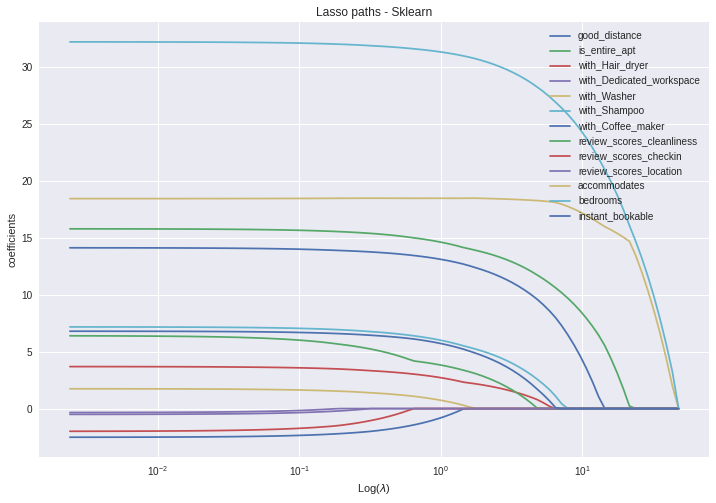

In [ ]:
# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = selected[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

We can remove then: instant_bookable, review_scores_checkin, review_scores_location

In [ ]:
selected2 = selected.copy()
selected2

['good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Dedicated_workspace',
 'with_Washer',
 'with_Shampoo',
 'with_Coffee_maker',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_location',
 'accommodates',
 'bedrooms',
 'instant_bookable']

In [ ]:
selected2.remove('with_Coffee_maker')
selected2.remove('review_scores_checkin')
selected2.remove('review_scores_location')
selected2.remove('instant_bookable')
selected2.remove('with_Dedicated_workspace')
selected2

['good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Washer',
 'with_Shampoo',
 'review_scores_cleanliness',
 'accommodates',
 'bedrooms']

try Lasso again

In [ ]:
X = data_subset.loc[:,selected2]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

(0.0014585456643563973,
 78.53315150195162,
 -1.5945952627651527,
 33.486500518068205)

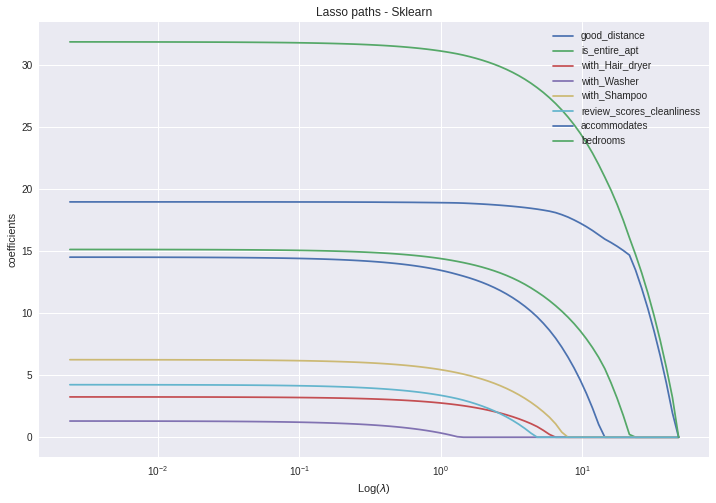

In [ ]:
# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = selected2[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

Now its much better. At the end lets remove accomodates value, sice it is srtrongly connected with bedrooms

In [ ]:
selected2_no_accomodates = selected2.copy()
selected2_no_accomodates.remove('accommodates')
selected2_no_accomodates

['good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Washer',
 'with_Shampoo',
 'review_scores_cleanliness',
 'bedrooms']

In [ ]:
# It will work better in the future, when it is rearanged:
selected2_no_accomodates = ['bedrooms', 'good_distance', 'is_entire_apt', 'with_Hair_dryer', 'with_Shampoo', 'review_scores_cleanliness']

#XGB Repeated

In [ ]:
from sklearn.preprocessing import StandardScaler
sc2 = StandardScaler()
scaledFeatures2 = sc2.fit_transform(data[selected2])
scaledFeatures2

array([[ 0.65099988, -1.54238858,  0.63113418, ...,  0.11740872,
        -1.13017939, -0.44853317],
       [ 0.65099988, -1.54238858,  0.63113418, ...,  0.55989798,
        -1.13017939, -0.44853317],
       [-1.53609858,  0.64834505,  0.63113418, ...,  0.11740872,
         0.89757169, -0.44853317],
       ...,
       [ 0.65099988,  0.64834505, -1.58444913, ...,         nan,
        -0.45426236, -0.44853317],
       [ 0.65099988,  0.64834505,  0.63113418, ...,         nan,
        -0.45426236, -0.44853317],
       [ 0.65099988,  0.64834505, -1.58444913, ...,         nan,
         0.89757169, -0.44853317]])

In [ ]:
# Load packages and create test set
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

X2 = scaledFeatures2
y = data["price"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42)

In [ ]:
#Initialize XGBoost classifier and find the best parameter sets with Grid Search CV
xgb_clf2 = xgb.XGBRegressor()
parameters = {'n_estimators': [80, 100, 120, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

[15:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 3, 'n_estimators': 80}


In [ ]:
# Xgb with best parameters
xgb_clf2 = xgb.XGBRegressor(n_estimators=80, max_depth=3)
xgb_clf2.fit(X_train2, y_train2)
y_test_pred2 = xgb_clf2.predict(X_test2)
print("R^2 score is: {0: .4f}".format(r2_score(y_test2, y_test_pred2)))
print("RMSE is: {0: .4f}".format(np.sqrt(mean_squared_error(y_test2, y_test_pred2))))

[15:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score is:  0.3369
RMSE is:  82.3684


Last try - without accomodates

In [ ]:
from sklearn.preprocessing import StandardScaler
sc2_no_accomodates = StandardScaler()
scaledFeatures2_no_accomodates = sc.fit_transform(data[selected2_no_accomodates])
scaledFeatures2_no_accomodates

array([[-0.44853317,  0.65099988, -1.54238858,  0.63113418, -1.10768703,
         0.11740872],
       [-0.44853317,  0.65099988, -1.54238858,  0.63113418,  0.90278208,
         0.55989798],
       [-0.44853317, -1.53609858,  0.64834505,  0.63113418, -1.10768703,
         0.11740872],
       ...,
       [-0.44853317,  0.65099988,  0.64834505, -1.58444913, -1.10768703,
                nan],
       [-0.44853317,  0.65099988,  0.64834505,  0.63113418, -1.10768703,
                nan],
       [-0.44853317,  0.65099988,  0.64834505, -1.58444913, -1.10768703,
                nan]])

In [ ]:
# Load packages and create test set
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

X2_no_accomodates = scaledFeatures2_no_accomodates
y = data["price"]
X_train2_no_accomodates, X_test2_no_accomodates, y_train2_no_accomodates, y_test2_no_accomodates = train_test_split(X2_no_accomodates, y, test_size=0.2, random_state=42)

In [ ]:
#Initialize XGBoost classifier and find the best parameter sets with Grid Search CV
xgb_clf2_no_accomodates = xgb.XGBRegressor()
parameters = {'n_estimators': [80, 100, 120, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train2_no_accomodates, y_train2_no_accomodates)
print(grid_search.best_params_)

[15:56:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 3, 'n_estimators': 80}


In [ ]:
# Xgb with best parameters
xgb_clf2_no_accomodates = xgb.XGBRegressor(n_estimators=80, max_depth=3)
xgb_clf2_no_accomodates.fit(X_train2_no_accomodates, y_train2_no_accomodates)
y_test_pred2_no_accomodates = xgb_clf2_no_accomodates.predict(X_test2_no_accomodates)
print("R^2 score is: {0: .4f}".format(r2_score(y_test2_no_accomodates, y_test_pred2_no_accomodates)))
print("RMSE is: {0: .4f}".format(np.sqrt(mean_squared_error(y_test2_no_accomodates, y_test_pred2_no_accomodates))))

[15:56:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score is:  0.2897
RMSE is:  85.2519


We will use this set of data for further predictions

#Shapley

In [ ]:
explainer = shap.TreeExplainer(xgb_clf)
X = data[selected]
shap_values = explainer.shap_values(X)
X.iloc[0,:]

good_distance                1.00
is_entire_apt                0.00
with_Hair_dryer              1.00
with_Dedicated_workspace     1.00
with_Washer                  1.00
with_Shampoo                 0.00
with_Coffee_maker            0.00
review_scores_cleanliness    4.74
review_scores_checkin        4.82
review_scores_location       4.80
accommodates                 1.00
bedrooms                     1.00
instant_bookable             0.00
Name: 0, dtype: float64

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
explainer2 = shap.TreeExplainer(xgb_clf2)
X2 = data[selected2]
shap_values2 = explainer2.shap_values(X2)
X2.iloc[0,:]

good_distance                1.00
is_entire_apt                0.00
with_Hair_dryer              1.00
with_Washer                  1.00
with_Shampoo                 0.00
review_scores_cleanliness    4.74
accommodates                 1.00
bedrooms                     1.00
Name: 0, dtype: float64

In [ ]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2[0,:], X2.iloc[0,:])

In [ ]:
explainer2_no_accomodates = shap.TreeExplainer(xgb_clf2_no_accomodates)
X2_no_accomodates = data[selected2_no_accomodates]
shap_values2_no_accomodates = explainer2_no_accomodates.shap_values(X2_no_accomodates)
X2_no_accomodates.iloc[0,:]

good_distance                1.00
is_entire_apt                0.00
with_Hair_dryer              1.00
with_Washer                  1.00
with_Shampoo                 0.00
review_scores_cleanliness    4.74
bedrooms                     1.00
Name: 0, dtype: float64

In [ ]:
shap.initjs()
shap.force_plot(explainer2_no_accomodates.expected_value, shap_values2_no_accomodates[0,:], X2_no_accomodates.iloc[0,:])

#Linear Regression

In [ ]:
selected

['good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Dedicated_workspace',
 'with_Washer',
 'with_Shampoo',
 'with_Coffee_maker',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_location',
 'accommodates',
 'bedrooms',
 'instant_bookable']

In [ ]:
selected2

['good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Washer',
 'with_Shampoo',
 'review_scores_cleanliness',
 'accommodates',
 'bedrooms']

In [ ]:
selected2_no_accomodates

['good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Washer',
 'with_Shampoo',
 'review_scores_cleanliness',
 'bedrooms']

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols('price ~ good_distance + is_entire_apt + with_Hair_dryer + with_Dedicated_workspace + with_Washer + with_Shampoo + with_Coffee_maker + review_scores_cleanliness + review_scores_checkin + review_scores_location + accommodates + bedrooms + instant_bookable', data=data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     74.30
Date:                Wed, 01 Jun 2022   Prob (F-statistic):          2.49e-153
Time:                        15:41:32   Log-Likelihood:                -9129.4
No. Observations:                1599   AIC:                         1.829e+04
Df Residuals:                    1585   BIC:                         1.836e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [ ]:
model2 = smf.ols('price ~ good_distance + is_entire_apt + with_Hair_dryer + with_Washer + with_Shampoo + review_scores_cleanliness + accommodates + bedrooms', data=data).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     117.9
Date:                Wed, 01 Jun 2022   Prob (F-statistic):          6.63e-155
Time:                        15:41:32   Log-Likelihood:                -9137.5
No. Observations:                1599   AIC:                         1.829e+04
Df Residuals:                    1590   BIC:                         1.834e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [ ]:
model2_no_accomodates = smf.ols('price ~ good_distance + is_entire_apt + with_Hair_dryer + with_Washer + with_Shampoo + review_scores_cleanliness + bedrooms', data=data).fit()

print(model2_no_accomodates.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     124.8
Date:                Wed, 01 Jun 2022   Prob (F-statistic):          2.34e-146
Time:                        15:41:32   Log-Likelihood:                -9159.9
No. Observations:                1599   AIC:                         1.834e+04
Df Residuals:                    1591   BIC:                         1.838e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

W can see, that we can remoove Washer, due to low p

In [ ]:
model_final = smf.ols('price ~ bedrooms + good_distance + is_entire_apt + with_Hair_dryer + with_Shampoo + review_scores_cleanliness', data=data).fit()

print(model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     145.4
Date:                Wed, 01 Jun 2022   Prob (F-statistic):          3.23e-147
Time:                        15:49:38   Log-Likelihood:                -9160.4
No. Observations:                1599   AIC:                         1.833e+04
Df Residuals:                    1592   BIC:                         1.837e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

#Ceteris paribus

Lets calculate number of bedrooms

In [ ]:
['good_distance', 'is_entire_apt', 'with_Hair_dryer', 'with_Shampoo', 'review_scores_cleanliness']
data_temp = pd.DataFrame({"bedrooms" : [x for x in range(30)]})
data_temp['good_distance'] = 1
data_temp['is_entire_apt'] = 1
data_temp['with_Hair_dryer'] = 1
data_temp['with_Shampoo'] = 1
data_temp['review_scores_cleanliness'] = 4.8
data_temp

data_temp.head()

,bedrooms,good_distance,is_entire_apt,with_Hair_dryer,with_Shampoo,review_scores_cleanliness
0,0,1,1,1,1,4.8
1,1,1,1,1,1,4.8
2,2,1,1,1,1,4.8
3,3,1,1,1,1,4.8
4,4,1,1,1,1,4.8


In [ ]:
# Code needed, to turn attribute names back anfter XGB modification
xgb_clf2_no_accomodates.get_booster().feature_names = ['bedrooms', 'good_distance', 'is_entire_apt', 'with_Hair_dryer', 'with_Shampoo', 'review_scores_cleanliness']
xgb_clf2_no_accomodates.get_booster().feature_names

['bedrooms',
 'good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Shampoo',
 'review_scores_cleanliness']

In [ ]:
xgb_clf2_no_accomodates.get_booster().feature_names

['bedrooms',
 'good_distance',
 'is_entire_apt',
 'with_Hair_dryer',
 'with_Shampoo',
 'review_scores_cleanliness']

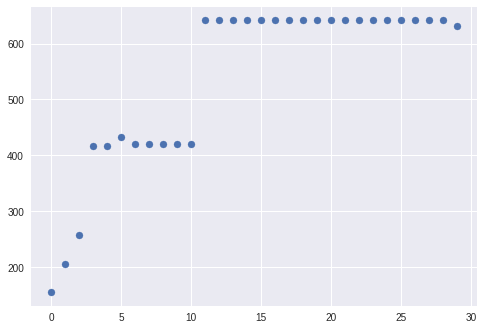

In [ ]:
data_subset = data.loc[:, selected2_no_accomodates + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)

#Predict
predictions_temp = xgb_clf2_no_accomodates.predict(data_temp)

#Plot
plt.scatter(x=data_temp.bedrooms, y=predictions_temp)
plt.show()

Here we can see, that really big raise is with 3 bedrooms, but it may be hard to buy - 2 bedrooms are also good